# Chennai Neighbourhood Analysis

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#imports)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Our country consists of many **hawkers** or **small-scale vendors**. The condition of these people is not good in our country. Many of them are very poor and many of them commit suicide because they are not able to pay their loans. Their condition is critical and they don't have proper knowledge about "Where to set up their business?" , "Which location will get the most of customers and will be ideal for sales?" as they don't have these answers they end up putting their stalls near to large stalls which sell the same thing and end up competing with them. As the large stalls have good infrastructure people get attracted to these stalls.<br>
**"The main objective is to find an ideal place for the hawkers to sell their items so that they could get maximum profit."**

## Data <a name="data"></a>

The data for this project has been retrieved and processed through multiple sources, considering the accuracy of the methods used.

### 1. Imports

Importing necessary libraries

In [1]:
from bs4 import BeautifulSoup #for web scraping
import requests
import pandas as pd #for dataframes
import numpy as np
import csv
from geopy.geocoders import Nominatim #for geological data
import folium
from sklearn.cluster import KMeans #for modelling
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Scraping Wikipedia page

The data of the neighbourhood in Chennai can be extracted out by web scraping using BeautifulSoup library for Python. The neighbourhood data is scraped from a Wikipedia web-page (https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Chennai)

In [2]:
source = requests.get('https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Chennai').text 
soup = BeautifulSoup(source, 'lxml')
pd.set_option('max_colwidth', 800)
pd.set_option('max_rows', 800)

In [3]:
csv_file = open('chennai.csv', 'w')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Neighbourhood'])

15

In [4]:
a=soup.find('div',class_='mw-category')
b=a.find_all('ul')
b.pop(0)
for x in b:
    c=x.find_all('a')
    for y in c:
        csv_writer.writerow([y.text])

In [5]:
csv_file.close()

### 3. Obtaining Geospatial Data

The file contents from Chennai.csv is retrieved into a Pandas DataFrame. The latitude and longitude of the neighbourhood are retrieved using Google Maps Geocoding API. The geometric location values are then stored into the initial dataframe. 

In [6]:
df = pd.read_csv('chennai.csv')
a=['Grant Lyon','Kellys','Manali New Town','Madhya Kailash Junction','Srinivasapuram','Ayyappa Nagar','Raja Nagar','Sai Ganesh Nagar','Periyar Nagar','Parameshwari Nagar','Tolgate','Perumbakkam','General Kumaramangalam Colony','Kumaran Nagar']
b=[ e +', Chennai' for e in a]
df['Neighbourhood'].replace(a,b,inplace=True)
#for x in df['Neighbourhood']:
 #   y=str(x)
  #  if y.find(',')==-1:
   #     y=y+', Chennai'
    #    df['Neighbourhood'].replace(x,y,inplace=True)     
df.head()

,Neighbourhood
0,Adambakkam
1,"Adyar, Chennai"
2,Agaram
3,Alandur
4,Alapakkam


In [8]:
lat=[]
lng=[]
for x in df['Neighbourhood']:  
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(x)
    try:
        lat1 = location.latitude
        long1 = location.longitude
        lat.append(lat1)
        lng.append(long1)
    except:
        lat.append(float('NaN'))
        lng.append(float('NaN'))
df['Latitude']=lat
df['Longitude']=lng

### 4. Data Cleaning

Outliers are removed and all the values that are not available in the dataframe are also removed. Finally, we get this table shown below:

In [9]:
df.dropna(subset=['Latitude','Longitude'],inplace=True)

In [10]:
df.reset_index(inplace = True, drop = True)
df.drop([2,41],inplace=True)
df.reset_index(inplace = True, drop = True)
df.head()

,Neighbourhood,Latitude,Longitude
0,Adambakkam,12.982221,80.209121
1,"Adyar, Chennai",13.006450,80.257779
2,Alandur,13.002822,80.171919
3,Alapakkam,13.049901,80.165435
4,Alwarpet,13.033860,80.254549


### 5. Creating Maps

Folium builds on the data wrangling strengths of the Python ecosystem and the mapping strengths of the leaflet.js library. All cluster visualization is done with the help of Folium which in turn generates a Leaflet map made using OpenStreetMap technology.

In [11]:
# create map of Chennai using latitude and longitude values
map_chennai = folium.Map(location=[13.0827,80.2707], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'],df['Longitude'],df['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chennai)  
    
map_chennai

### 6. Getting Forsquare data

In [12]:
CLIENT_ID = 'UPIMGYWTF1KXYTQ5QFI5C3BRZS2UH52QOY33VPN5EWRFFYZB' # your Foursquare ID
CLIENT_SECRET = 'XPTV1S4EKIITPKZJZNS3GRGLOSDBIFOW1H5Z32AAPL301PTJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UPIMGYWTF1KXYTQ5QFI5C3BRZS2UH52QOY33VPN5EWRFFYZB
CLIENT_SECRET:XPTV1S4EKIITPKZJZNS3GRGLOSDBIFOW1H5Z32AAPL301PTJ


### 7. Getting Nearby Venues

From the location data obtained after Web Scraping and Geocoding, the venue data is found out by passing in the required parameters to the Foursquare API and creating another DataFrame to contain all the venue details along with the respective neighbourhood.

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
chennai_venues=getNearbyVenues(names=df['Neighbourhood'],
                               latitudes=df['Latitude'],
                               longitudes=df['Longitude']
                              )
chennai_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adambakkam,12.982221,80.209121,Return Gifts Online,12.982387,80.208338,Gift Shop
1,Adambakkam,12.982221,80.209121,arun icecream,12.983447,80.207847,Dessert Shop
2,Adambakkam,12.982221,80.209121,Sutherland,12.981002,80.205200,IT Services
3,Adambakkam,12.982221,80.209121,Bistro,12.983193,80.205020,Indian Restaurant
4,"Adyar, Chennai",13.006450,80.257779,Bombay Brassiere,13.006961,80.256419,North Indian Restaurant


In [15]:
chennai_venues.shape

(703, 7)

## Methodology <a name="methodology"></a>

A thorough analysis of the principles of methods, rules, and postulates employed that have been made to ensure the inferences to be made are as accurate as possible.

### Data Insights

After all venues of each neighbourhood are obtained than a graph is plotted to know which neighbourhood has most venue which shows that Adayar has most of the venues whereas Puzhal has the least

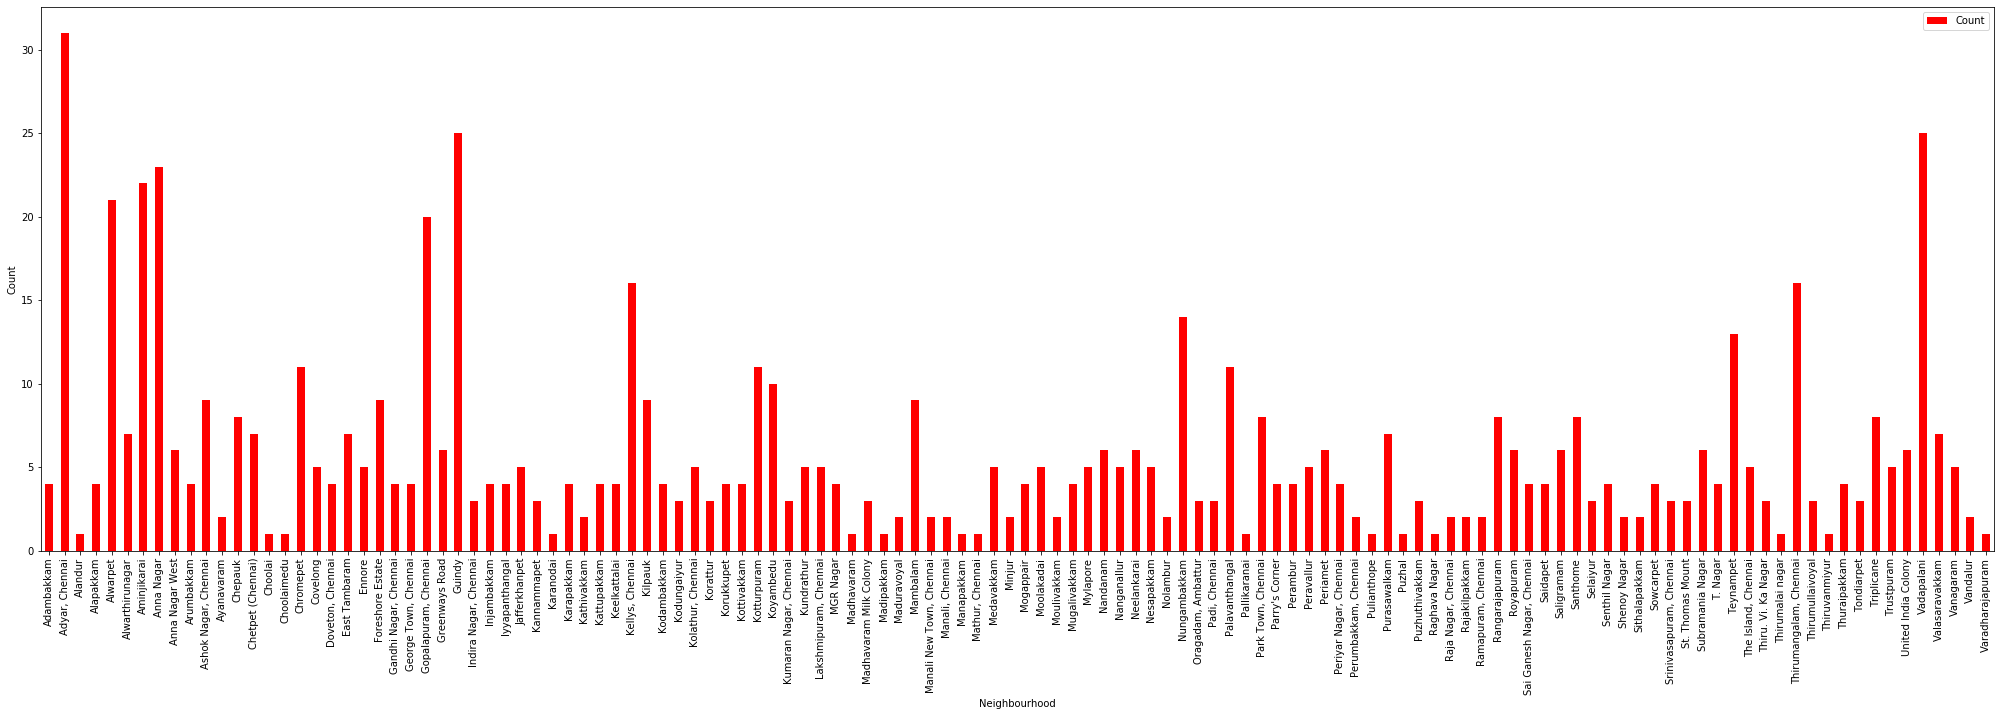

In [45]:
dfx=pd.DataFrame(chennai_venues.groupby('Neighbourhood').count(),columns=['Venue'])
dfx.rename(columns={'Venue':'Count'},inplace=True)
dfx.plot(kind='bar',figsize=(35,10),color='red')
plt.ylabel('Count')
plt.show()

In [16]:
print('There are {} uniques categories.'.format(len(chennai_venues['Venue Category'].unique())))

There are 140 uniques categories.


In [17]:
# one hot encoding
chennai_onehot = pd.get_dummies(chennai_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chennai_onehot['Neighbourhood'] = chennai_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [chennai_onehot.columns[-1]] + list(chennai_onehot.columns[:-1])
chennai_onehot = chennai_onehot[fixed_columns]

chennai_onehot.head()

,Neighbourhood,ATM,African Restaurant,Airport Service,Andhra Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Tennis Court,Thai Restaurant,Tourist Information Center,Train,Train Station,Vegetarian / Vegan Restaurant,Video Store,Whisky Bar,Women's Store,Yoga Studio
0,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Adyar, Chennai",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
chennai_onehot.shape

(705, 141)

In [19]:
chennai_grouped=chennai_onehot.groupby('Neighbourhood').mean().reset_index()
chennai_grouped.head()

,Neighbourhood,ATM,African Restaurant,Airport Service,Andhra Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Tennis Court,Thai Restaurant,Tourist Information Center,Train,Train Station,Vegetarian / Vegan Restaurant,Video Store,Whisky Bar,Women's Store,Yoga Studio
0,Adambakkam,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,"Adyar, Chennai",0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035714,...,0.0,0.000000,0.0,0.0,0.0,0.035714,0.0,0.0,0.0,0.0
2,Alandur,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,Alapakkam,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,Alwarpet,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.041667,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [20]:
chennai_grouped.shape

(125, 141)

### 8. Getting most common venues

Due to high variability in the venues, only the top 10 common venues are selected and a new DataFrame is made, which is used to train the K-means Clustering algorithm.

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
df_venues_sorted = pd.DataFrame(columns=columns)
df_venues_sorted['Neighbourhood'] = chennai_grouped['Neighbourhood']

for ind in np.arange(chennai_grouped.shape[0]):
    df_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chennai_grouped.iloc[ind, :], num_top_venues)

df_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adambakkam,Indian Restaurant,Restaurant,Dessert Shop,IT Services,Convenience Store,Cosmetics Shop,Cricket Ground,Daycare,Department Store,Fried Chicken Joint
1,"Adyar, Chennai",Indian Restaurant,Electronics Store,North Indian Restaurant,Juice Bar,Movie Theater,Café,Bookstore,Snack Place,Fast Food Restaurant,Grocery Store
2,Alandur,Airport Service,Yoga Studio,Farmers Market,Frozen Yogurt Shop,Fried Chicken Joint,Food Court,Food,Flower Shop,Fast Food Restaurant,Event Space
3,Alapakkam,Indian Restaurant,Fast Food Restaurant,ATM,Airport Service,Gift Shop,Daycare,Department Store,Dessert Shop,Diner,Electronics Store
4,Alwarpet,Japanese Restaurant,Coffee Shop,Bakery,Restaurant,Pharmacy,Chinese Restaurant,Fast Food Restaurant,Café,Breakfast Spot,Sandwich Place


In [23]:
chennai_grouped_clustering=chennai_grouped.drop('Neighbourhood',1)
chennai_grouped_clustering.head()

,ATM,African Restaurant,Airport Service,Andhra Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Tennis Court,Thai Restaurant,Tourist Information Center,Train,Train Station,Vegetarian / Vegan Restaurant,Video Store,Whisky Bar,Women's Store,Yoga Studio
0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035714,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.035714,0.0,0.0,0.0,0.0
2,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.041667,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


### 9. Selecting appropriate K-value

Silhouette Score is a measure of how similar an object is to its cluster (cohesion) compared to other clusters (separation). The silhouette ranges from -1 to +1, where a high value indicates that the object is well matched to its cluster and poorly matched to neighbouring clusters. Based on the Silhouette Score of various clusters below 20, the optimal cluster size is determined.

In [61]:
def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [62]:
max_range = 20 # Maximum range of clusters

In [63]:
from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    c = chennai_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(c)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(c, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

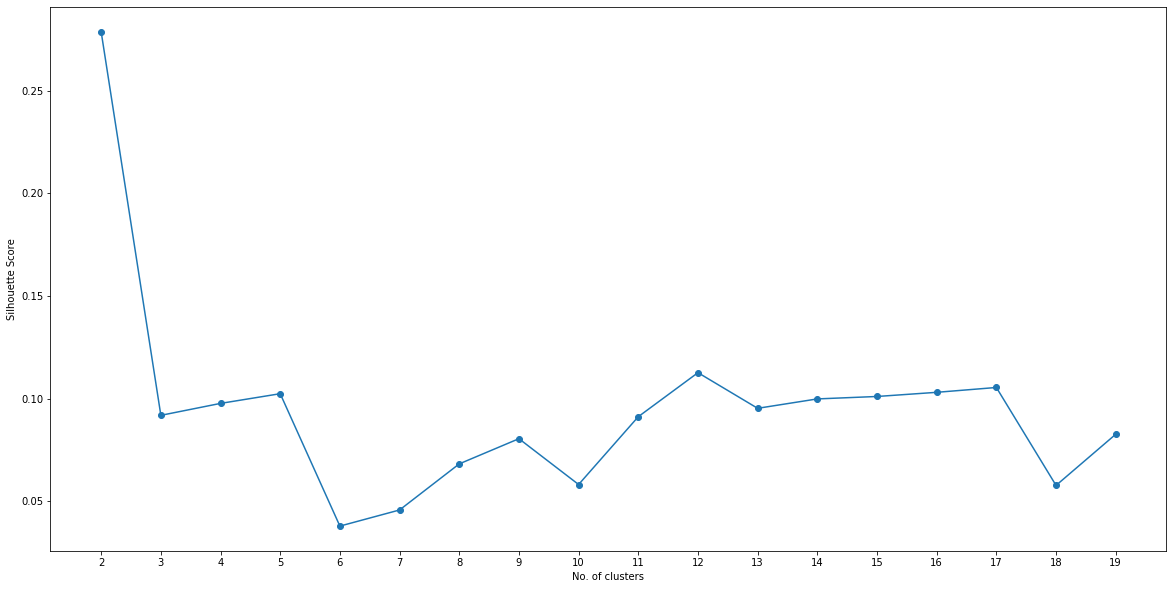

In [64]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

### 10. Modeling

The venue data is then trained using K-means Clustering Algorithm to get the desired clusters to base the analysis on. K-means was chosen as the variables (Venue Categories) are huge, and in such situations, K-means will be computationally faster than other clustering algorithms.

In [42]:
kclusters = 12 #taking second highest silhoutte value so that the data gets divided into more groups having similar features which was not possible in k=2

# Run k-means clustering
c = chennai_grouped_clustering
kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit(c)

In [45]:
#df_venues_sorted.drop(['Cluster Labels'],axis=1,inplace=True)
df_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

## Analysis <a name="analysis"></a>

Analyse each of the clusters to identify the characteristics of each cluster and the neighborhoods in them.

In [46]:
chennai_merged = df
chennai_merged = chennai_merged.join(df_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
chennai_merged.dropna(inplace = True)
chennai_merged['Cluster Labels'] = chennai_merged['Cluster Labels'].astype(int)
chennai_merged.head()

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adambakkam,12.982221,80.209121,3,Indian Restaurant,Restaurant,Dessert Shop,IT Services,Convenience Store,Cosmetics Shop,Cricket Ground,Daycare,Department Store,Fried Chicken Joint
1,"Adyar, Chennai",13.006450,80.257779,3,Indian Restaurant,Electronics Store,North Indian Restaurant,Juice Bar,Movie Theater,Café,Bookstore,Snack Place,Fast Food Restaurant,Grocery Store
2,Alandur,13.002822,80.171919,3,Airport Service,Yoga Studio,Farmers Market,Frozen Yogurt Shop,Fried Chicken Joint,Food Court,Food,Flower Shop,Fast Food Restaurant,Event Space
3,Alapakkam,13.049901,80.165435,0,Indian Restaurant,Fast Food Restaurant,ATM,Airport Service,Gift Shop,Daycare,Department Store,Dessert Shop,Diner,Electronics Store
4,Alwarpet,13.033860,80.254549,3,Japanese Restaurant,Coffee Shop,Bakery,Restaurant,Pharmacy,Chinese Restaurant,Fast Food Restaurant,Café,Breakfast Spot,Sandwich Place


### 11. Clusters on Map

The neighbourhood is divided into n clusters where n is the number of clusters found using the optimal approach. The clustered neighbourhood are visualized using different colours to make them distinguishable.

In [47]:
# Create map
map_clusters = folium.Map(location=[13.0827,80.2707], zoom_start=12)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chennai_merged['Latitude'], chennai_merged['Longitude'], chennai_merged['Neighbourhood'], chennai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' (Cluster ' + str(cluster + 1) + ')', parse_html=True)
    map_clusters.add_child(
        folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7))
       
map_clusters

### 12. Examining the clusters

#### Cluster 1 contains Indian restaurants and it is the second-largest cluster.

In [48]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + np.arange(4, chennai_merged.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Alapakkam,Indian Restaurant,Fast Food Restaurant,ATM,Airport Service,Gift Shop,Daycare,Department Store,Dessert Shop,Diner,Electronics Store
43,Karapakkam,Indian Restaurant,Shopping Plaza,Bakery,Frozen Yogurt Shop,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Event Space
51,"Kolathur, Chennai",Indian Restaurant,Electronics Store,Department Store,Cosmetics Shop,Cricket Ground,Daycare,Dessert Shop,Diner,Furniture / Home Store,Event Space
52,Korattur,Indian Restaurant,Pharmacy,Dessert Shop,Campground,Event Space,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market
69,Manapakkam,Indian Restaurant,Juice Bar,Event Space,Fried Chicken Joint,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Yoga Studio
71,Medavakkam,Indian Restaurant,Vegetarian / Vegan Restaurant,Electronics Store,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Event Space,Diner
74,Mogappair,Indian Restaurant,Bus Station,Sandwich Place,Convenience Store,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Event Space
106,Rajakilpakkam,Indian Restaurant,Event Space,Fried Chicken Joint,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Electronics Store,Furniture / Home Store
117,Senthil Nagar,Indian Restaurant,Department Store,Electronics Store,Cricket Ground,Daycare,Cosmetics Shop,Dessert Shop,Diner,Furniture / Home Store,Event Space
121,"Srinivasapuram, Chennai",Indian Restaurant,Italian Restaurant,Coffee Shop,Resort,Yoga Studio,Event Space,Food Court,Food,Flower Shop,Fast Food Restaurant


#### Cluster 2 contains Ice Cream Shops and ATM

In [49]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + np.arange(4, chennai_merged.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Anna Nagar West,Café,Ice Cream Shop,Park,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Event Space,Electronics Store
15,Ayanavaram,Department Store,Restaurant,Yoga Studio,Event Space,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Diner
17,Chetpet (Chennai),Indian Restaurant,Train Station,Performing Arts Venue,Department Store,Café,Ice Cream Shop,Women's Store,Hotel Bar,Food Court,Cricket Ground
19,Choolai,Ice Cream Shop,Fast Food Restaurant,Yoga Studio,Event Space,Fried Chicken Joint,Food Court,Food,Flower Shop,Farmers Market,Electronics Store
61,"Lakshmipuram, Chennai",ATM,Department Store,Park,Indian Restaurant,Hyderabadi Restaurant,Cricket Ground,Daycare,Cosmetics Shop,Dessert Shop,Fried Chicken Joint
63,Madhavaram Milk Colony,ATM,Park,Ice Cream Shop,Airport Service,Furniture / Home Store,Daycare,Department Store,African Restaurant,Dessert Shop,Diner
83,Nesapakkam,Ice Cream Shop,Café,Department Store,Restaurant,Indian Restaurant,Hotel,Food,Cosmetics Shop,Cricket Ground,Daycare
94,Peravallur,Ice Cream Shop,Coffee Shop,Train Station,Train,Light Rail Station,Yoga Studio,Event Space,Food Court,Food,Flower Shop
104,Raghava Nagar,Ice Cream Shop,Fast Food Restaurant,Diner,Yoga Studio,Event Space,Fried Chicken Joint,Food Court,Food,Flower Shop,Farmers Market
137,Trustpuram,Ice Cream Shop,Café,Park,Bakery,Bus Station,Fast Food Restaurant,Food Court,Food,Flower Shop,Farmers Market


#### Cluster 3 contains Grocery Store and Yoga Studio.

In [50]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + np.arange(4, chennai_merged.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
64,Madipakkam,Grocery Store,Yoga Studio,Furniture / Home Store,Fried Chicken Joint,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Event Space
133,Thiruvanmiyur,Performing Arts Venue,Grocery Store,Yoga Studio,Event Space,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Electronics Store


#### Cluster 4 contains Multicuisine restaurants, Clothing Stores and many other basic amenities shops and it is the largest cluster

In [51]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + np.arange(4, chennai_merged.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adambakkam,Indian Restaurant,Restaurant,Dessert Shop,IT Services,Convenience Store,Cosmetics Shop,Cricket Ground,Daycare,Department Store,Fried Chicken Joint
1,"Adyar, Chennai",Indian Restaurant,Electronics Store,North Indian Restaurant,Juice Bar,Movie Theater,Café,Bookstore,Snack Place,Fast Food Restaurant,Grocery Store
2,Alandur,Airport Service,Yoga Studio,Farmers Market,Frozen Yogurt Shop,Fried Chicken Joint,Food Court,Food,Flower Shop,Fast Food Restaurant,Event Space
4,Alwarpet,Japanese Restaurant,Coffee Shop,Bakery,Restaurant,Pharmacy,Chinese Restaurant,Fast Food Restaurant,Café,Breakfast Spot,Sandwich Place
5,Alwarthirunagar,Clothing Store,Pizza Place,Café,Fast Food Restaurant,Gym,Food Court,Food,Flower Shop,Farmers Market,Event Space
6,Aminjikarai,Clothing Store,Pizza Place,Furniture / Home Store,Fast Food Restaurant,Electronics Store,Event Space,Café,Multiplex,Scenic Lookout,Shopping Mall
8,Anna Nagar,Indian Restaurant,Electronics Store,Chinese Restaurant,Fast Food Restaurant,Café,Pizza Place,Bakery,Department Store,Clothing Store,Middle Eastern Restaurant
12,Arumbakkam,Men's Store,Pizza Place,Department Store,Liquor Store,Yoga Studio,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market
13,"Ashok Nagar, Chennai",Indian Restaurant,Ice Cream Shop,Sandwich Place,Coffee Shop,Dessert Shop,Diner,Pizza Place,Historic Site,Health & Beauty Service,IT Services
16,Chepauk,Indian Restaurant,Cricket Ground,Light Rail Station,Bus Station,Sports Club,Yoga Studio,Farmers Market,Food Court,Food,Flower Shop


#### Cluster 5 contains ATM and Event Space

In [52]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 4, chennai_merged.columns[[0] + np.arange(4, chennai_merged.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
42,Karanodai,ATM,Event Space,Fried Chicken Joint,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Electronics Store,Furniture / Home Store
60,Kundrathur,ATM,Pharmacy,Bus Station,Event Space,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Electronics Store
67,"Manali New Town, Chennai",ATM,Event Space,Fried Chicken Joint,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Electronics Store,Furniture / Home Store
68,"Manali, Chennai",ATM,Event Space,Fried Chicken Joint,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Electronics Store,Furniture / Home Store
70,"Mathur, Chennai",ATM,Event Space,Fried Chicken Joint,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Electronics Store,Furniture / Home Store
90,Pallikaranai,ATM,Other Repair Shop,Cosmetics Shop,Cricket Ground,Daycare,Department Store,Dessert Shop,Diner,Frozen Yogurt Shop,Electronics Store


#### Cluster 6 contains Coffee shops and Yoga Studio.

In [53]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 5, chennai_merged.columns[[0] + np.arange(4, chennai_merged.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
118,Shenoy Nagar,Coffee Shop,Yoga Studio,Event Space,Fried Chicken Joint,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Electronics Store


#### Cluster 7 contains Barber Shop and Yoga Studio

In [54]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 6, chennai_merged.columns[[0] + np.arange(4, chennai_merged.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
102,Puzhal,Salon / Barbershop,Yoga Studio,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Event Space,Electronics Store,Frozen Yogurt Shop


#### Cluster 8 contains Movie Theatre

In [55]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 7, chennai_merged.columns[[0] + np.arange(4, chennai_merged.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
39,Jafferkhanpet,Movie Theater,Multicuisine Indian Restaurant,Vegetarian / Vegan Restaurant,Event Space,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Yoga Studio
65,Maduravoyal,Movie Theater,Yoga Studio,Event Space,Fried Chicken Joint,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Electronics Store


#### Cluster 9 contains Train Station and ATM.

In [56]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 8, chennai_merged.columns[[0] + np.arange(4, chennai_merged.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Ennore,Train Station,ATM,Art Gallery,Event Space,Fried Chicken Joint,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market
32,Greenways Road,Train Station,Yoga Studio,Rock Club,Dessert Shop,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Event Space
44,Kathivakkam,ATM,Train Station,Event Space,Fried Chicken Joint,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Electronics Store
73,Minjur,Train Station,Scenic Lookout,Yoga Studio,Event Space,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Electronics Store


#### Cluster 10 contains Hotel and Bars

In [57]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 9, chennai_merged.columns[[0] + np.arange(4, chennai_merged.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Choolaimedu,Burger Joint,Hotel,Yoga Studio,Farmers Market,Fried Chicken Joint,Food Court,Food,Flower Shop,Fast Food Restaurant,Event Space
41,Kannammapet,Hotel,Bus Station,Yoga Studio,Farmers Market,Fried Chicken Joint,Food Court,Food,Flower Shop,Fast Food Restaurant,Event Space
72,MGR Nagar,Juice Bar,Hotel,Hostel,Bus Station,Yoga Studio,Event Space,Food Court,Food,Flower Shop,Fast Food Restaurant
79,Nandanam,Playground,Hotel,Bar,Sports Bar,Yoga Studio,Event Space,Food Court,Food,Flower Shop,Fast Food Restaurant
88,"Padi, Chennai",Miscellaneous Shop,Bar,Yoga Studio,Furniture / Home Store,Fried Chicken Joint,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market
95,Periamet,Hotel,Indian Restaurant,Soccer Stadium,Vegetarian / Vegan Restaurant,Juice Bar,Bookstore,Farmers Market,Fried Chicken Joint,Food Court,Food
97,"Perumbakkam, Chennai",Hotel,Badminton Court,Yoga Studio,Farmers Market,Fried Chicken Joint,Food Court,Food,Flower Shop,Fast Food Restaurant,Event Space
134,Thuraipakkam,Golf Course,Food Court,Hotel,Bus Station,Yoga Studio,Farmers Market,Food,Flower Shop,Fast Food Restaurant,Event Space


#### Cluster 11 contains the Platform and Electronics Store.

In [58]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 10, chennai_merged.columns[[0] + np.arange(4, chennai_merged.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
100,Pulianthope,Platform,Electronics Store,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Event Space,Diner,Frozen Yogurt Shop
144,Vandalur,ATM,Platform,African Restaurant,Event Space,Fried Chicken Joint,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market


#### Cluster 12 contains a Smoke shop and Yoga Studio.

In [59]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 11, chennai_merged.columns[[0] + np.arange(4, chennai_merged.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,Madhavaram,Smoke Shop,Yoga Studio,Event Space,Food Court,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Electronics Store,Frozen Yogurt Shop


## Results and Discussion <a name="results"></a>

After analysing the various clusters produced by the Machine learning algorithm, Cluster no. 5, is a good option for the vendors who sell flowers as in these areas there are no flower shops nearby and Event space is the most common venues and mostly in all the events, they need flowers. Hence flower shops near Karanodai, Kundrathur, Manali New Town and many other places in cluster 5 can be profitable.<br><br>
Cluster no. 9 is also a good option as it contains train station as a common venue and in a train station there is a lot of public movement also there are no flower shops and food stalls nearby so vendors can open their food stall here as most of the people get hungry while reaching the station hence the vendors can earn a large profit. Hence opening shops at Enore, Greenways road, kathivakkam and minjur will be beneficial.<br><br>
Cluster no. 1 is the best place to open a grocery store or a vegetable store as there are lot of Indian restaurants near these areas they will always need vegetables and grocery hence by opening a stall in Alapakkam, Karapakkam, Manapakkam and many more areas near cluster 1 will help street vendors gain more profit.

## Conclusion <a name="conclusion"></a>

This project helps a person get a better understanding of the neighbourhoods with respect to the most common venues in that neighbourhood. It is always helpful to make use of technology to stay one step ahead i.e. finding out more about places before moving into a neighbourhood. Also, the small scale vendors after knowing the right place to do their business will make an immense profit, which will lead to a better lifestyle of the vendors and hence they could help the Indian economy in one way or the other. Hence the GDP of India will increase and if it goes on increasing than India will become a developed country soon. The prospect of this project is to make the algorithm better and efficient so that it could analyse the whole country and it could help all the category of people.